## Import the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Google Drive / Kaggle directory setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Read train and test data

In [0]:
train_data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/block_2_train_data_final.h5')
test_data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/test2.h5')

## Create validation data set

In [0]:
val_split = int(len(train_data) * 0.10)
validation_data = train_data[:val_split+1]

In [0]:
train_data.shape, test_data.shape, validation_data.shape

((204801, 9), (37762, 9), (20481, 9))

## Create the LSTM model function

In [0]:
def LSTM_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=30, 
              y_target_col=8, 
              epochs=10, 
              batch_size=64):
 
  # scale data
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  validation_data = scaler.fit_transform(validation_data)

  # get input arrays
  
  X_train = []
  y_train = []

  for i in range(look_back, train_data.shape[0]):
      X_train.append(train_data[i-look_back:i])
      y_train.append(train_data[i, y_target_col])
    
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val = []
  y_val = []

  for i in range(look_back, validation_data.shape[0]):
    X_val.append(validation_data[i-look_back:i])
    y_val.append(validation_data[i, y_target_col])

  X_val, y_val = np.array(X_val), np.array(y_val)

  # build the model
  model = Sequential()

  model.add(CuDNNLSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 9)))
  # model.add(Dropout(0.2)) # model has better results w/o Dropout
  model.add(CuDNNLSTM(units=64, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss = 'mean_squared_error',  metrics=['mse', 'mae'])

  # callbacks  
  callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
  
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
  
  callback_tensorboard = TensorBoard(log_dir='C:\\Users\\Laptop\\Desktop\\tensor')

  callbacks = [callback_early_stopping,
             callback_reduce_lr,
             callback_tensorboard]
  
  # train   
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

  # predict
  past_60_min = test_data.tail(60)
  df = past_60_min.append(test_data, ignore_index = True)
  inputs = scaler.transform(df)

  X_test = []
  y_test = []

  for i in range(look_back, inputs.shape[0]):
    X_test.append(inputs[i-look_back:i])
    y_test.append(inputs[i, y_target_col])

  X_test, y_test = np.array(X_test), np.array(y_test) 

  y_pred = model.predict(X_test)
  scale = 1/scaler.scale_[y_target_col]
  y_pred = y_pred*scale
  y_test = y_test*scale

  # metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
  
  # plot
  plt.figure(figsize=(14,5))
  plt.plot(y_test, color = 'red', label = 'Real')
  plt.plot(y_pred, color = 'blue', label = 'Predicted')
  plt.title('Mill DP')
  plt.xlabel('Minutes')
  plt.ylabel('Mill DP')
  plt.legend()
  plt.show()
    
  result = model.evaluate(x=X_test, y=y_test)
  print("loss (test-set):", result)
  print('LSTM: ', mae, mse, r2)

  return y_test, y_pred

## Train the LSTM model

Train on 204741 samples, validate on 20421 samples
Epoch 1/10
204741/204741 [==============================] - 129s 628us/sample - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0225 - val_loss: 3.1357e-04 - val_mean_squared_error: 3.1357e-04 - val_mean_absolute_error: 0.0087
Epoch 2/10
204736/204741 [============================>.] - ETA: 0s - loss: 4.9757e-04 - mean_squared_error: 4.9757e-04 - mean_absolute_error: 0.0137
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
204741/204741 [==============================] - 128s 628us/sample - loss: 4.9756e-04 - mean_squared_error: 4.9756e-04 - mean_absolute_error: 0.0137 - val_loss: 3.2929e-04 - val_mean_squared_error: 3.2929e-04 - val_mean_absolute_error: 0.0103
Epoch 3/10
204736/204741 [============================>.] - ETA: 0s - loss: 4.0721e-04 - mean_squared_error: 4.0721e-04 - mean_absolute_error: 0.0103
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
204741/204741 

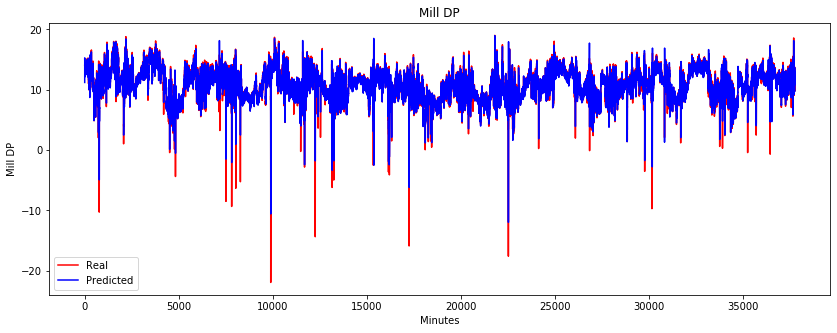

37762/37762 [==============================] - 16s 431us/sample - loss: 111.3798 - mean_squared_error: 111.3798 - mean_absolute_error: 10.3175
loss (test-set): [111.379799531644, 111.37983, 10.317467]
LSTM:  0.4882236457175831 0.8692645203082797 0.8682390467090035


In [0]:
y_test, y_pred_lstm = LSTM_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=60, 
              y_target_col=8,
              epochs=10, 
              batch_size=64)

## Code to lunch Tensorboard

In [0]:
tensorboard --logdir C:\Users\Laptop\Desktop\tensor

## Create the GRU model function

In [0]:
def GRU_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=30, 
              y_target_col=8, 
              epochs=10, 
              batch_size=64):
 
  # scale data
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  validation_data = scaler.fit_transform(validation_data)

  # get input arrays
  
  X_train = []
  y_train = []

  for i in range(look_back, train_data.shape[0]):
      X_train.append(train_data[i-look_back:i])
      y_train.append(train_data[i, y_target_col])
    
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val = []
  y_val = []

  for i in range(look_back, validation_data.shape[0]):
    X_val.append(validation_data[i-look_back:i])
    y_val.append(validation_data[i, y_target_col])

  X_val, y_val = np.array(X_val), np.array(y_val)

  # build the model
  model = Sequential()

  model.add(CuDNNGRU(units=256, return_sequences=True, input_shape=(X_train.shape[1], 9)))
  #model.add(Dropout(0.2))
  model.add(CuDNNGRU(units=32, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss = 'mean_squared_error',  metrics=['mse', 'mae'])

  # callbacks  
  callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
  
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
  
  callback_tensorboard = TensorBoard(log_dir='C:\\Users\\Laptop\\Desktop\\tensor')

  callbacks = [callback_early_stopping,
             callback_reduce_lr,
             callback_tensorboard]
  
  # train   
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

  # predict
  past_60_min = test_data.tail(60)
  df = past_60_min.append(test_data, ignore_index = True)
  inputs = scaler.transform(df)

  X_test = []
  y_test = []

  for i in range(look_back, inputs.shape[0]):
    X_test.append(inputs[i-look_back:i])
    y_test.append(inputs[i, y_target_col])

  X_test, y_test = np.array(X_test), np.array(y_test) 

  y_pred = model.predict(X_test)
  scale = 1/scaler.scale_[y_target_col]
  y_pred = y_pred*scale
  y_test = y_test*scale

  # metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')

  # plot
  plt.figure(figsize=(14,5))
  plt.plot(y_test, color = 'red', label = 'Real')
  plt.plot(y_pred, color = 'blue', label = 'Predicted')
  plt.title('Mill DP')
  plt.xlabel('Minutes')
  plt.ylabel('Mill DP')
  plt.legend()
  plt.show()
    
  result = model.evaluate(x=X_test, y=y_test)
  print("loss (test-set):", result)
  print('GRU: ', mae, mse, r2)

  return y_test, y_pred, history

## Train the GRU model

Train on 204741 samples, validate on 20421 samples
Epoch 1/10
204741/204741 [==============================] - 106s 516us/sample - loss: 0.0013 - val_loss: 6.0609e-04
Epoch 2/10
204741/204741 [==============================] - 105s 511us/sample - loss: 5.1002e-04 - val_loss: 4.1821e-04
Epoch 3/10
204741/204741 [==============================] - 105s 512us/sample - loss: 4.8961e-04 - val_loss: 3.0070e-04
Epoch 4/10
204736/204741 [============================>.] - ETA: 0s - loss: 4.6773e-04
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
204741/204741 [==============================] - 105s 512us/sample - loss: 4.6773e-04 - val_loss: 3.2497e-04
Epoch 5/10
204672/204741 [============================>.] - ETA: 0s - loss: 4.0245e-04
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001.
204741/204741 [==============================] - 105s 511us/sample - loss: 4.0251e-04 - val_loss: 2.8615e-04
Epoch 6/10
204741/204741 [=============================

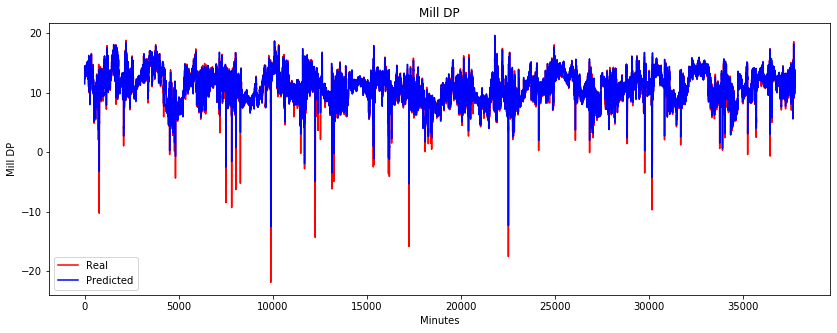

37762/37762 [==============================] - 13s 339us/sample - loss: 111.2372
loss (test-set): 111.23723280366072


In [0]:
y_test, y_pred_gru, history_gru = GRU_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=60, 
              y_target_col=8,
              epochs=10, 
              batch_size=64)

## Code to lunch Tensorboard

In [0]:
tensorboard --logdir C:\Users\Laptop\Desktop\tensor

UsageError: Line magic function `%tensorboard` not found.


## Plot the results


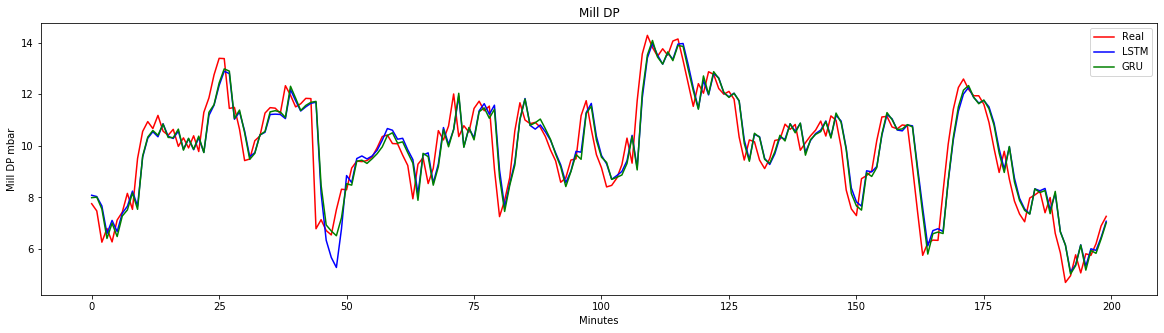

In [0]:
# plot
a = 28000
b = a+200
plt.figure(figsize=(20,5))
plt.plot(y_test[a:b], color = 'red', label = 'Real')
plt.plot(y_pred_lstm[a:b], color = 'blue', label = 'LSTM')
plt.plot(y_pred_gru[a:b], color = 'green', label = 'GRU')
plt.title('Mill DP')
plt.xlabel('Minutes')
plt.ylabel('Mill DP mbar')
plt.legend()
plt.show()

## Model metrics

In [0]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm, multioutput='variance_weighted')

mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
r2_gru = r2_score(y_test, y_pred_gru, multioutput='variance_weighted')

print('Block 1 Metrics')
print('LSTM: ', mae_lstm, mse_lstm, r2_lstm)
print('GRU: ', mae_gru, mse_gru, r2_gru)

## Save the results

In [0]:
y_test1 = y_test.flatten()
y_pred_lstm1 = y_pred_lstm.flatten()
y_pred_gru1 = y_pred_gru.flatten()

In [0]:
block_2_results = pd.DataFrame({'y_test': y_test1, 'y_pred_lstm': y_pred_lstm1, 'y_pred_gru': y_pred_gru1})
block_2_results

,y_test,y_pred_lstm,y_pred_gru
0,14.06,11.073660,11.470675
1,14.18,14.464620,14.512300
2,13.54,13.388373,13.433566
3,13.48,13.103772,13.271366
4,13.08,13.291405,13.416237
...,...,...,...
37757,11.44,13.257173,13.230211
37758,9.79,11.158136,10.973970
37759,11.51,9.828759,10.869824
37760,10.11,11.142091,12.499422


In [0]:
block_2_results.to_hdf('block_2_results.h5', key='df')